<a href="https://colab.research.google.com/github/mark-rtb/simple_recommendation/blob/master/simple_recommendation_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Test task 1**

Using the dataset for Amazon Fine Food Reviews (https://www.kaggle.com/snap/amazon-fine-food-reviews) create a simple recommendation engine which recommends products to users based on their previous experience and rates.

Solution has to return three recommendations for every passed UserId and these recommended products have not match to products reviewed by user.

Чтобы получить доступ к данным с kaggle нужно создать API токен и загрузить его в colab

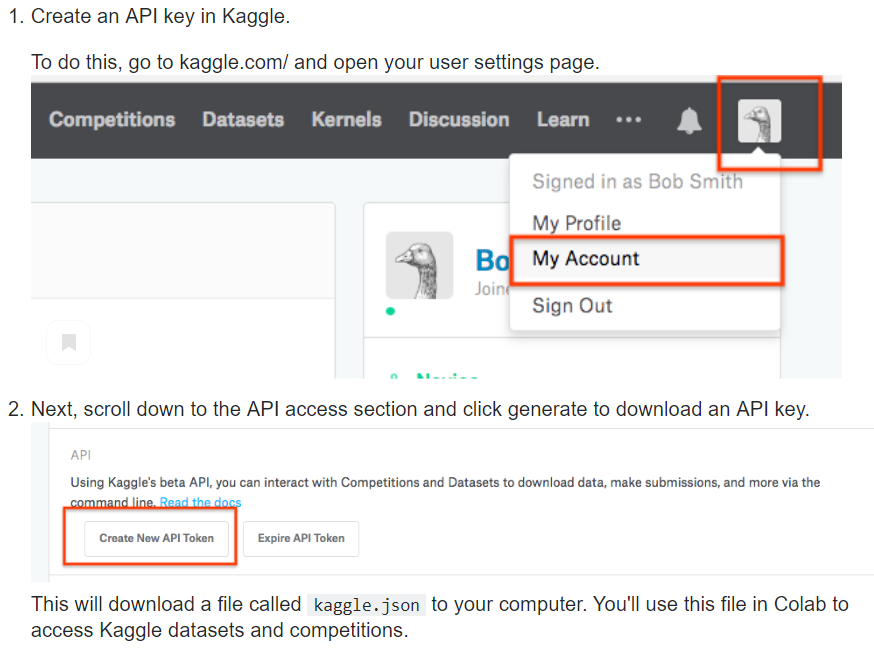

In [0]:
from google.colab import files
files.upload() 

In [190]:
# Установка библиотек и зависимостей, для загрузки данных
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json
!pip install -q kaggle
!pip install -q kaggle-cli
!kaggle datasets download -d snap/amazon-fine-food-reviews

kaggle.json
total 4
-rw------- 1 root root 63 Feb  9 17:34 kaggle.json
{"username":"markrtb","key":"5e67f6a11a8606115b2e0f4a92c3d169"}Downloading amazon-fine-food-reviews.zip to /content/amazon-fine-food-reviews
 96% 232M/242M [00:01<00:00, 154MB/s]
100% 242M/242M [00:01<00:00, 132MB/s]


In [0]:
# импортируем библиотеки
import os
import zipfile
import sqlite3
import pandas as pd
from fastai.collab import CollabDataBunch, collab_learner

In [0]:
with zipfile.ZipFile('amazon-fine-food-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('amazon-fine-food-reviews')

In [192]:
os.chdir('amazon-fine-food-reviews')
print(os.listdir())

['Reviews.csv', 'hashes.txt', 'database.sqlite']


In [194]:
con=sqlite3.connect('database.sqlite')
df_data=pd.read_sql_query(""" SELECT * from Reviews""", con)[['UserId', 'ProductId', 'Score', 'Time']]
df_data.head()

,UserId,ProductId,Score,Time
0,A3SGXH7AUHU8GW,B001E4KFG0,5,1303862400
1,A1D87F6ZCVE5NK,B00813GRG4,1,1346976000
2,ABXLMWJIXXAIN,B000LQOCH0,4,1219017600
3,A395BORC6FGVXV,B000UA0QIQ,2,1307923200
4,A1UQRSCLF8GW1T,B006K2ZZ7K,5,1350777600


По условиям задания, нужно использовать только данные об оценках пользователей. Поэтому используем только столбцы с идентификаторами пользователя и продукта, а так же оценку.

In [196]:
data = CollabDataBunch.from_df(df_data, user_name='UserId', item_name='ProductId', rating_name='Score')
data.show_batch()

UserId,ProductId,target
A2SZLNSI5KOQJT,B007M832YY,4.0
A3T29DKWJGSNPH,B002I9X4TU,5.0
AAA0TUKS5VBSA,B000E1HVR0,2.0
A34M2CRL6JDXBB,B008O2EHNC,5.0
A1BL9MWYKTIHA3,B000GAW23W,3.0


# Создаем объект модели рекомендательной системы.

Чтобы не усложнять расчеты используем модель на основе скрытых факторов. 

В основе модели скрытых факторов лежит метод сингулярного разложения (SVD). 
Аналитическое решение задачи SVD сталкивается со множеством проблемм, основные это разреженность матрицы оценок и вычислительная сложность. Однако такую задачу можно рассматривать как задачу оптимизации, и применять универсальные методы оптимизации. Один из самых простых подходов заключается в использовании метода градиентного спуска для итеративного уточнения значений скрытых факторов.

In [0]:
model_temp = collab_learner(data, n_factors=50, y_range=(int(df_data['Score'].min()), int(df_data['Score'].max())),  model_dir="/tmp/model/", path="/tmp/")

Чтобы оценить качество модели, обучение будем проводить на тренировочной части данных, а оценку на валидационной. В качестве метрики используем *MSE*.

In [198]:
model_temp.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,2.284398,2.225854,00:56
1,2.018283,2.036263,00:56
2,1.966967,1.982471,00:56
3,1.869651,1.927677,00:56
4,1.696820,1.918950,00:56


Качество на валидационной выборке в __ не высоко, однако даже при таком показателе модель может давать адекватные рекомендации. 


# Обучение полной модели.

Чтобы давать рекомендации для всех пользователей, необходимо обучить модель на всех данных

In [0]:
data_full = CollabDataBunch.from_df(df_data, valid_pct=0, user_name='UserId', item_name='ProductId', rating_name='Score')
full_model = collab_learner(data_full, n_factors=50, y_range=(int(df_data['Score'].min()), int(df_data['Score'].max())),  model_dir=model_dir, path=path)

In [200]:
full_model.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,2.147330,#na#,01:03
1,2.064570,#na#,01:03
2,1.939179,#na#,01:03
3,1.832900,#na#,01:04
4,1.740865,#na#,01:02


Сохраним модель.

In [0]:
full_model.save('rec_model')

# Пример рекомендации трех рецептов, которые пользователь раньше не оценивал

ЧТобы загрузить модель, создадим объект модели, и загрузим в него веса.

In [0]:
model_recomend_food = collab_learner(data_full, n_factors=50, y_range=(int(df_data['Score'].min()), int(df_data['Score'].max())),  model_dir=model_dir, path=path)

In [204]:
model_recomend_food.load('rec_model')

CollabLearner(data=TabularDataBunch;

Train: LabelList (568454 items)
x: CollabList
UserId A3SGXH7AUHU8GW; ProductId B001E4KFG0; ,UserId A1D87F6ZCVE5NK; ProductId B00813GRG4; ,UserId ABXLMWJIXXAIN; ProductId B000LQOCH0; ,UserId A395BORC6FGVXV; ProductId B000UA0QIQ; ,UserId A1UQRSCLF8GW1T; ProductId B006K2ZZ7K; 
y: FloatList
5.0,1.0,4.0,2.0,5.0
Path: .;

Valid: LabelList (0 items)
x: CollabList

y: FloatList

Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(256060, 50)
  (i_weight): Embedding(74259, 50)
  (u_bias): Embedding(256060, 1)
  (i_bias): Embedding(74259, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('/tmp'), model_dir='/tmp/model/', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=[], layer_groups=[Sequential(
  (0): Embedding(256060, 50)
  (

Создается функция рекомендации рецептов

In [0]:
def food_recommendation(user_id, model_rec, base_data, number_food=3):
    """
    Printing the three recipe indexes that are most relevant to the transferred user
    input variable: 
        user_id, str user ID
        model_rec, model recommendation model
        base_data, pandas DataFrame database containing users and recommendations
        number_food, int number of recipes to recommend (3 by default)
    """
  
    user_w = model_rec.weight([user_id], is_item=False)

    list_food = list(base_data.loc[base_data['UserId']==user_id]['ProductId'])

    list_new_food = list(pd.unique(base_data.loc[~base_data['ProductId'].isin(list_food)]['ProductId']))

    foor_w = learn.weight(list_new_food, is_item=True)

    matrix_recomend = foor_w*user_w

    recomwnd_rating = torch.sum(matrix_recomend, dim=1)

    idx = (-np.array(recomwnd_rating)).argsort()[:number_food]
    
    for index in idx:
        print(list_new_food[index])




Для выбранного пользователя рекомендуются три рецепта, которые пользователь ранее не оценивал.

In [206]:
food_recommendation('A395BORC6FGVXV', model_recomend_food, df_data, number_food=3)

B005PXZ6JM
B000REI2X6
B001E5DXEU


# Выводы

Данную систему рекомендаций можно рассматривать как mvp.

Существенно улучшить рекомендации можно добавив данные из текстов обзоров (выделить категории блюд (суп, десерт и т.д.) данные по удельному колличеству специальных продуктов (специи, соль, сахар и т.д.), контекстные данные о пользователях (пол, возраст, регион проживания и тд.), а так же использовать временную составляющую.

При построении такой сложной модели, среднеквадратичное отклонение не отражает качество модели в полной мере. В таком случае адекватнее было бы применять одновременно несколько оценок (mse, DCG(накопленная взвешенная релевантность), serendipity(привлекательность), catalog coverage(охват каталога)
И все эти оценки лучше выполнять на нескольких временных интервалах, при этом предпочтение отдается модели не только с самыми высокими показателями но и с наименьшей дисперсией показателей во времени.